In [1]:
using Pkg
Pkg.activate(joinpath(Pkg.devdir(),"WebotsSim"));

In [2]:
using LightGraphs, MetaGraphs
using LinearAlgebra
using DataStructures
using JuMP, MathOptInterface
using Gurobi
using TOML
using Random

using GraphUtils
using TaskGraphs
using CRCBS
using WebotsSim
using GridWorldPathFollowing

┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/TaskGraphs/apcwx.ji for TaskGraphs [6635cb54-791c-11e9-2805-8512ad3937f9]
└ @ Base loading.jl:1190
┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/WebotsSim/GxeZZ.ji for WebotsSim [cb813d94-c6e3-11e9-14ba-bfd77c549807]
└ @ Base loading.jl:1190


In [3]:
include(joinpath(dirname(pathof(WebotsSim)),"..","test","notebooks","render_tools.jl"));

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/kylebrown/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


# Experiments:

Generate 4 environments for all experiments

In [4]:
env_graphs = []
envs = []
num_obstacle_cells = 64
for (i,n) in enumerate([2,4,8])
    obs_w = Int(sqrt(num_obstacle_cells)/n)
    env = construct_regular_factory_world(;
        n_obstacles_x=n,
        n_obstacles_y=n,
        obs_width = [obs_w;obs_w],
        obs_offset = [obs_w;obs_w],
        env_pad = [1;1],
        env_offset = [1,1],
#         env_scale = 0.5, # cell_width
#         transition_time = 2.0,
        env_scale = 0.25, # this is essentially the robot diameter
        transition_time = 1.0,
    )
    filename = string(WebotsSim.ENVIRONMENT_DIR,"/env_",i,".toml")
    open(filename,"w") do io
        TOML.print(io,env)
    end
    # graphics_filename = string(WebotsSim.ENVIRONMENT_DIR,"/env_",i,".svg")
    # visualize_env(env) |> SVG(graphics_filename)
    push!(envs, env)
end

In [5]:
i = 2;
set_default_plot_size(10cm,10cm);
filename = string(WebotsSim.ENVIRONMENT_DIR,"/env_",i,".toml");
factory_env = read_env(filename);
env_graph = factory_env.graph;
dist_matrix = get_dist_matrix(env_graph);
# p = visualize_env(factory_env)
# p |> PDF(joinpath("/home/kylebrown/Repositories/task_graphs_icra_paper/graphics","env_graph.pdf"))

# Generate texture map for webots factory floor

In [6]:
# set_default_graphic_size(10cm,10cm)
# caution_tape(0.1,10);

In [7]:
# set_default_graphic_size(10cm,10cm)
# taped_square(0.1)

In [8]:
# # set_default_graphic_size(20cm,20cm)
# p = render_factory_floor(factory_env;floor_color=RGB(0.4,0.4,0.4))
# # p |> SVG("floor.svg", 8cm, 8cm)
# p |> PNG("floor.png", 8inch, 8inch;dpi=1024)
# p

# Record Video

In [9]:
problem_id = 158
problem_filename = joinpath(PROBLEM_DIR,string("problem",problem_id,".toml"))
# results_filename = joinpath(RESULTS_DIR,string(:full_solver),string("results",problem_id,".toml"))
# toml_dict = TOML.parsefile(results_filename);
# robot_paths = Vector{Vector{Int}}(toml_dict["robot_paths"]);
# object_paths = Vector{Vector{Int}}(toml_dict["object_paths"]);
# @show length(robot_paths),length(object_paths);

In [27]:
problem_def = read_problem_def(problem_filename);
project_spec, r0, s0, sF = problem_def.project_spec,problem_def.r0,problem_def.s0,problem_def.sF
project_spec, problem_spec, object_ICs, object_FCs, robot_ICs = construct_task_graphs_problem(
        project_spec, r0, s0, sF, dist_matrix);
# Solve the problem
solver = PC_TAPF_Solver(verbosity=0,LIMIT_A_star_iterations=5*nv(env_graph));
solution, assignment, cost, search_env = high_level_search!(
    solver, env_graph, project_spec, problem_spec, robot_ICs, Gurobi.Optimizer);

robot_paths = convert_to_vertex_lists(solution);
object_paths = get_object_paths(solution,search_env);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
CBS: Optimal Solution Found! Cost = (92.0, 0.0, 740.0, 0.0)



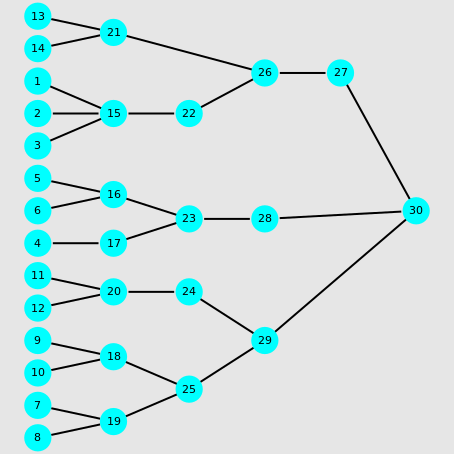

In [179]:
delivery_graph = construct_delivery_graph(project_spec,length(object_paths))
canvas_height,canvas_width,x,y,lines,shapes,fill_colors,text_strings = get_graph_bfs(delivery_graph.graph;r=0.18,textsize=6pt)
set_default_graphic_size(12cm,12cm)
display_graph_bfs(canvas_height,canvas_width,x,y,lines,shapes,fill_colors,text_strings)

In [162]:
function display_live_project_graph(search_env,delivery_graph,t,canvas_height,canvas_width,x,y,lines,shapes,fill_colors,text_strings;
        inactive_color=colorant"orange",
        active_color=colorant"lime",
        closed_color=colorant"gray"
    )
    cache = search_env.cache
    color_vec = map(v->inactive_color,vertices(delivery_graph.graph))
    for v in 1:get_num_vtxs(project_schedule)
        vtx_id = get_vtx_id(project_schedule, v)
        if typeof(vtx_id) <: ActionID
            node = get_node_from_id(project_schedule,vtx_id)
            if typeof(node) <: COLLECT
                if (cache.t0[v] <= t)
                    color_vec[get_id(get_object_id(node))] = active_color
                end
            elseif typeof(node) <: DEPOSIT
                if (cache.tF[v] <= t)
                    color_vec[get_id(get_object_id(node))] = closed_color
                end
            end
        end
    end
    display_graph_bfs(canvas_height,canvas_width,x,y,lines,shapes,color_vec,text_strings)
end

display_live_project_graph (generic function with 1 method)

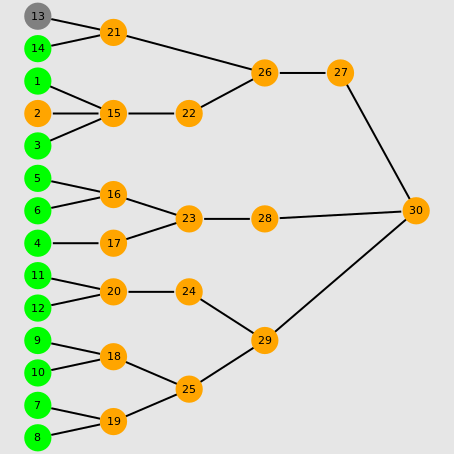

In [180]:
t = 10
display_live_project_graph(search_env,delivery_graph,t,canvas_height,canvas_width,x,y,lines,shapes,fill_colors,text_strings)

In [169]:
function get_graph_bfs(graph,v=0;
        shape_function = (G,v,x,y,r)->Compose.circle(x,y,r),
        color_function = (G,v,x,y,r)->"cyan",
        text_function = (G,v,x,y,r)->string(v),
        mode=:leaf_aligned,
        ϵ=0.000000001,
        edge_pad=1.1,
        r = 0.2,
        textsize=10pt)

    G = deepcopy(graph)
    if v == 0
        end_vtxs = [v for v in vertices(G) if length(outneighbors(G,v)) == 0]
        s = BFS_state(0,0,0)
        for v in end_vtxs
            s = bfs!(G,v,s)
        end
    else
        s = BFS_state(0,0,0)
        s = bfs!(G,v,s)
    end
    set_default_graphic_size((s.d_max*2)cm,(s.w)cm)
    if mode == :leaf_aligned
        x = [get_prop(G,v,:height)+0.5 for v in vertices(G)]
    else
        x = s.d_max .- [get_prop(G,v,:depth)-0.5 for v in vertices(G)]
    end
    y = [get_prop(G,v,:center) for v in vertices(G)]
    rp = edge_pad*r; # padded radius for plotting
    lines = Vector{Compose.Form}()
    for e in edges(G)
        dx = (x[e.dst] - x[e.src])
        dy = (y[e.dst] - y[e.src])
        d = sqrt(dx^2 + dy^2)
        push!(lines,
            line([
                (x[e.src] + (rp)*dx/d, y[e.src] + (rp)*dy/d),
                (x[e.dst] - (rp)*dx/d, y[e.dst] - (rp)*dy/d)
                ])
        )
    end
    shapes = map(i->shape_function(G,i,x[i],y[i],r),1:nv(graph))
    fill_colors = map(i->color_function(G,i,x[i],y[i],r),1:nv(graph))
    text_strings = map(i->text_function(G,i,x[i],y[i],r),1:nv(graph))

    return s.d_max,s.w,x,y,lines,shapes,fill_colors,text_strings
end

function display_graph_bfs(canvas_height,canvas_width,x,y,lines,shapes,fill_colors,text_strings;
    textsize=8pt,
    background_color=RGB(0.9,0.9,0.9)
    )
    N = length(x)
    compose(context(units=UnitBox(0,0,canvas_height,canvas_width)),
        (context(),[text(x[i],y[i],text_strings[i],hcenter,vcenter) for i in 1:N]...,
            stroke("black"),fontsize(textsize), font("futura")),
        map(i->(context(),shapes[i],fill(fill_colors[i])),1:N)...,
        (context(),lines...,stroke("black")),
        (context(),rectangle(),fill(background_color)))
end

function GraphPlottingBFS.plot_graph_bfs(graph,v=0;kwargs...)
    display_graph_bfs(get_graph_bfs(graph,v;kwargs...)...;kwargs...)
end

In [12]:
start_vtxs, start_headings, instructions = convert_solution_to_gridworld_instructions(factory_env,robot_paths);

In [13]:
initialize_webots_world_file(factory_env,start_vtxs,start_headings,instructions;filename=string("world",problem_id,".wbt"),box_height=0.125)

In [14]:
# tf = maximum(map(p->length(p),robot_paths))
# set_default_plot_size(18cm,18cm)
# record_video(joinpath(VIDEO_DIR,string("problem",problem_id,".webm")),t->render_paths(t,robot_paths,object_paths);tf=tf)

# Improve animation

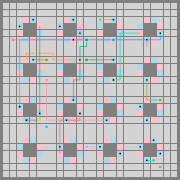

In [15]:
set_default_plot_size(18cm,18cm)
visualize_env(search_env,factory_env,5;robot_paths=robot_paths,object_paths=object_paths)

In [181]:
tf = maximum(map(p->length(p),robot_paths))
# set_default_plot_size(18cm,18cm)
# record_video(
#     joinpath(VIDEO_DIR,string("problem",problem_id,".webm")),
#     t->visualize_env(search_env,factory_env,t;robot_paths=robot_paths,object_paths=object_paths);
#     tf=tf,fps=31.25,dt=1/31.25)
set_default_graphic_size(16cm,12cm)
record_video(
    joinpath(VIDEO_DIR,string("project_graph",problem_id,".webm")),
    t->display_live_project_graph(search_env,delivery_graph,t,
        canvas_height,canvas_width,x,y,lines,shapes,fill_colors,text_strings);
    tf=tf,fps=31.25,dt=1/31.25)

Process(`rm -rf /tmp/tmp2pin2F`, ProcessExited(0))

In [67]:
function get_node_shape(search_env::SearchEnv,graph,v,x,y,r)
    project_schedule = search_env.schedule
    cache = search_env.cache
    node_id = get_vtx_id(project_schedule,get_prop(graph,v,:vtx_id))
    if typeof(node_id) <: ActionID
        return Compose.circle(x,y,r)
    elseif typeof(node_id) <: RobotID
        return Compose.ngon(x,y,r,4)
    elseif typeof(node_id) <: ObjectID
        return Compose.ngon(x,y,r,3)
    elseif typeof(node_id) <: OperationID
        return Compose.circle(x,y,r)
    end
end
function get_node_color(search_env::SearchEnv,graph,v,x,y,r)
    project_schedule = search_env.schedule
    cache = search_env.cache
    node_id = get_vtx_id(project_schedule,get_prop(graph,v,:vtx_id))
    if typeof(node_id) <: ActionID
        return "cyan"
    elseif typeof(node_id) <: RobotID
        return "lime"
    elseif typeof(node_id) <: ObjectID
        return "orange"
    elseif typeof(node_id) <: OperationID
        return "red"
    end
end
function get_node_text(search_env::SearchEnv,graph,v,x,y,r)
    project_schedule = search_env.schedule
    cache = search_env.cache
    v_ = get_prop(graph,v,:vtx_id)
    string(cache.t0[v_]," - ",cache.tF[v_],"\n",cache.local_slack[v_]," - ",cache.slack[v_])
end

get_node_text (generic function with 4 methods)

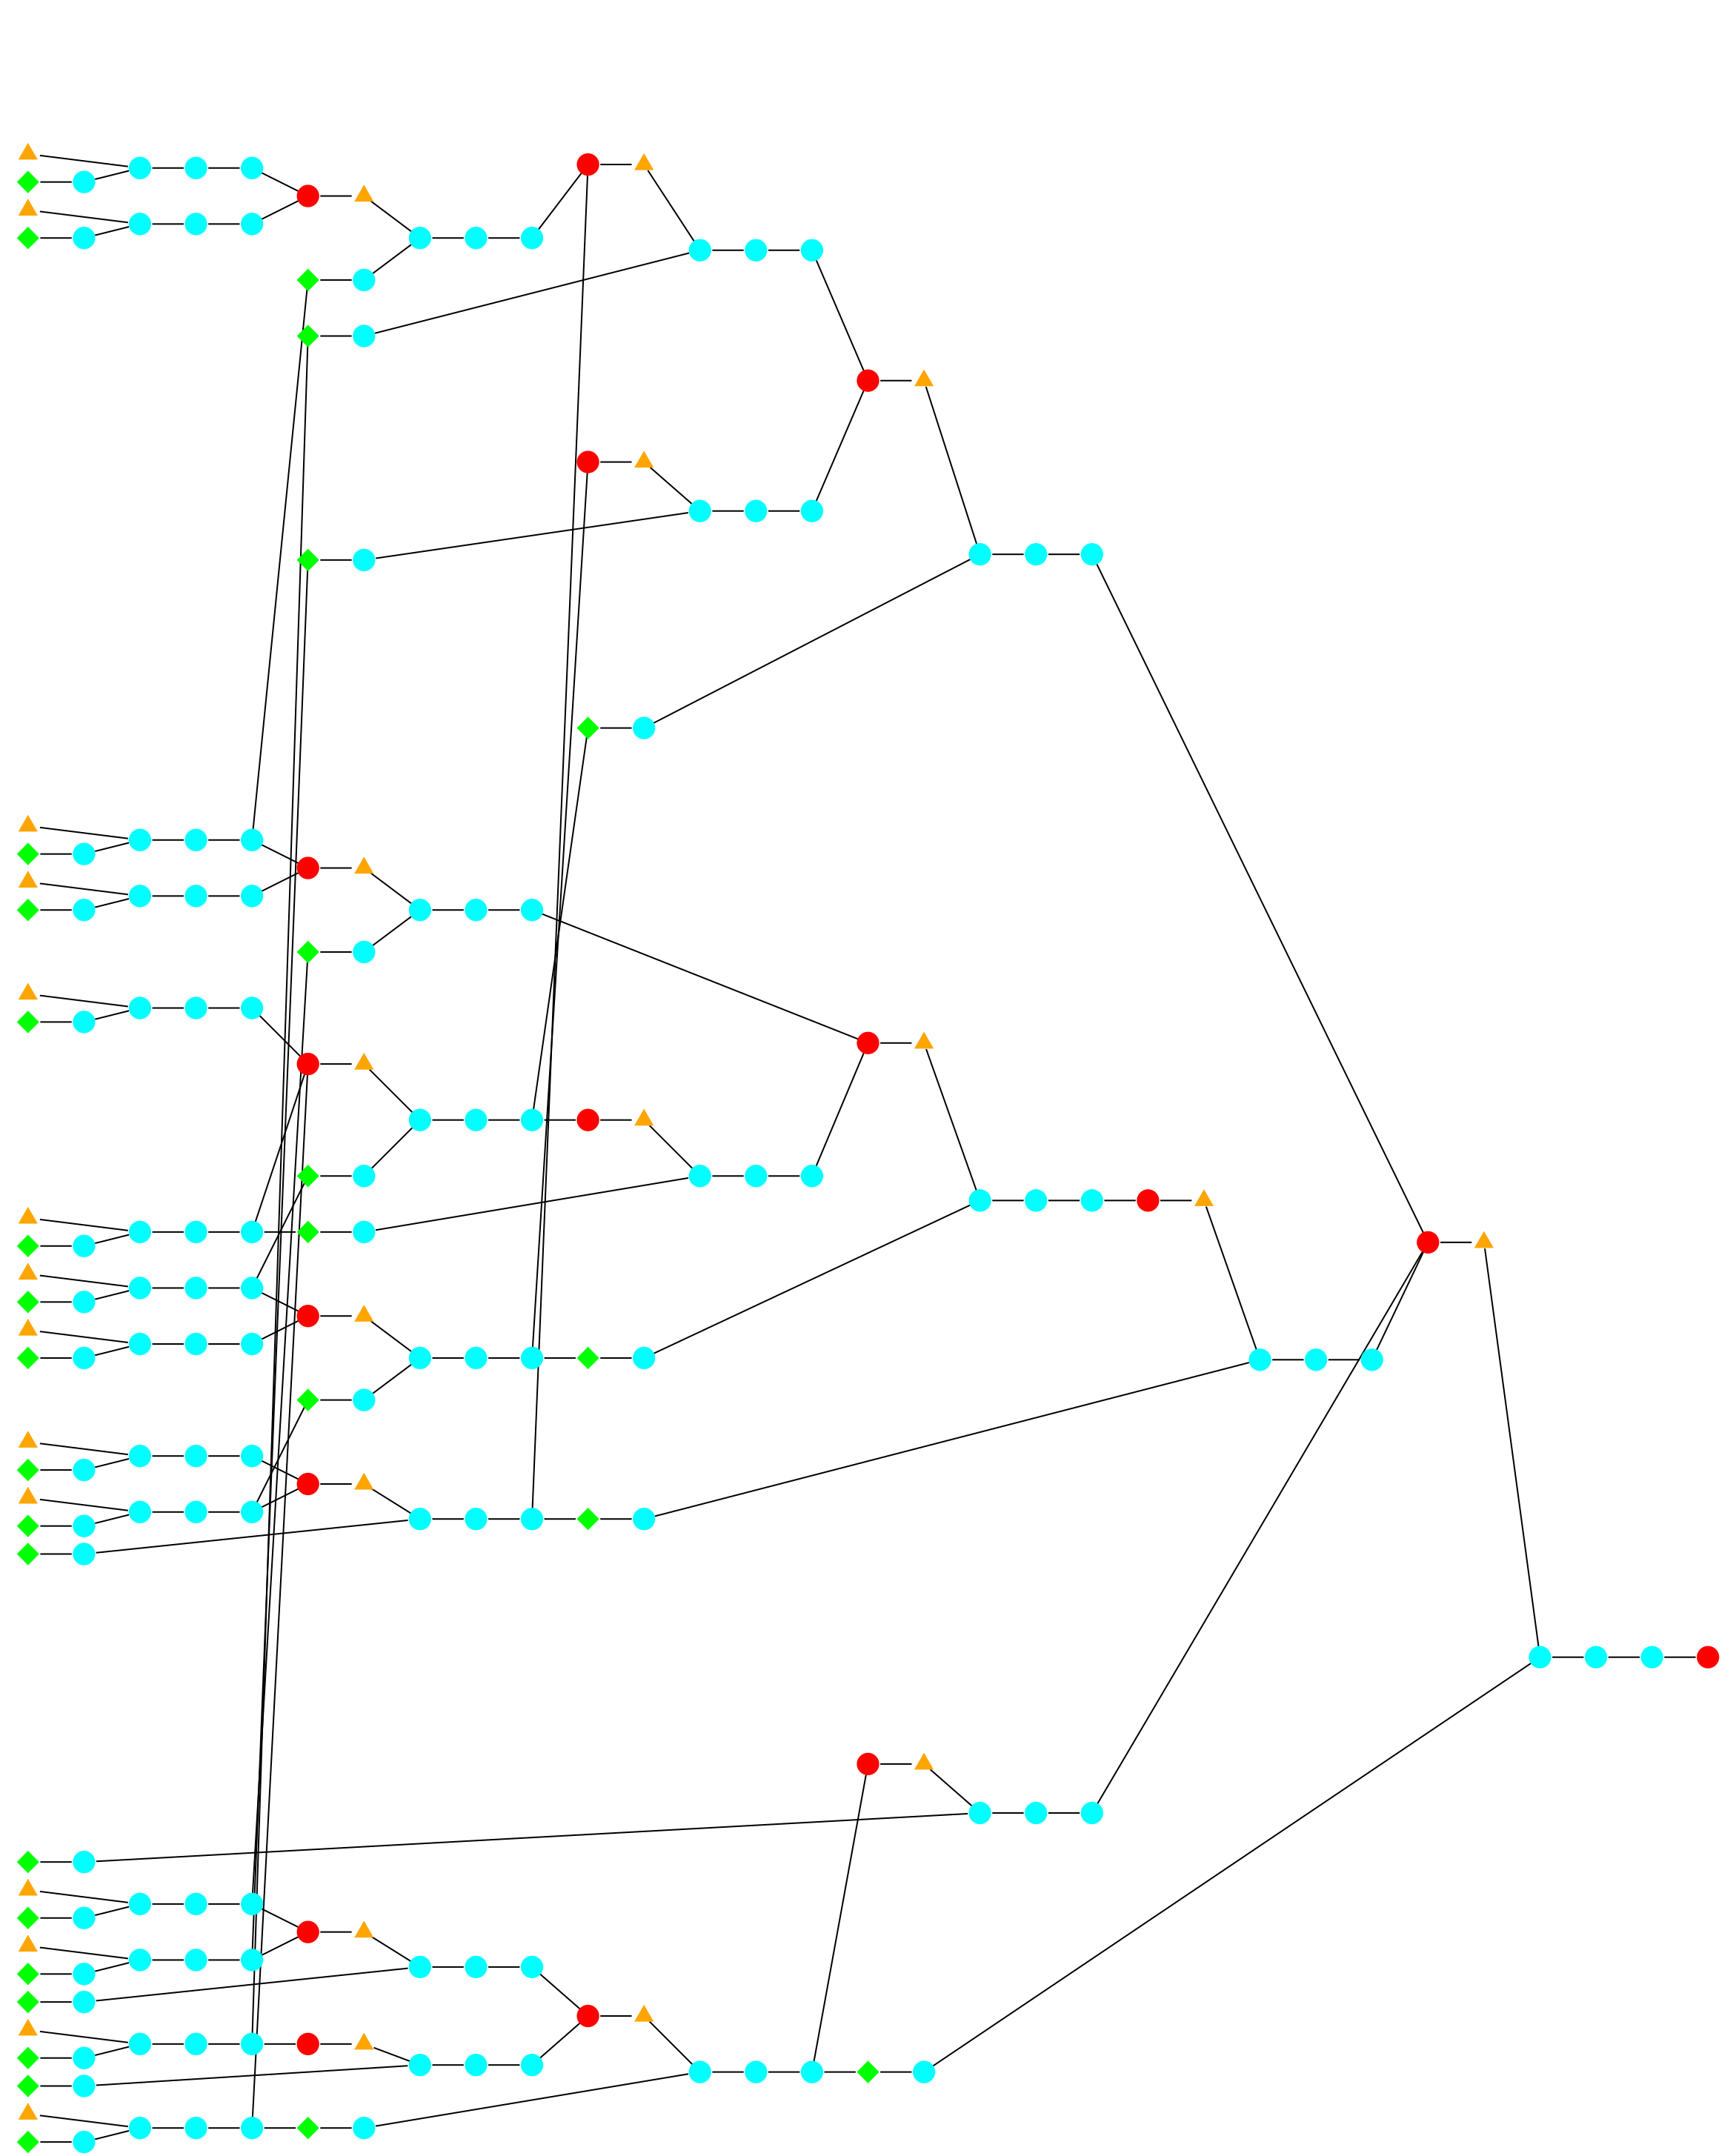

In [69]:
project_schedule=search_env.schedule
rg = get_display_metagraph(project_schedule;f=(v,p)->"",remove_leaf_robots=true)
# rg = get_display_metagraph(env.schedule;f=(v,p)->string(env.cache.t0[v]," - ",env.cache.tF[v],
#         "\n",env.cache.local_slack[v]," - ",env.cache.slack[v]))
plot_graph_bfs(rg;
    shape_function=(args...)->get_node_shape(search_env,args...),
    color_function=(args...)->get_node_color(search_env,args...),
#     text_function=(args...)->get_node_text(search_env,args...)
    text_function=(args...)->""
)

In [61]:
function TaskGraphs.get_display_metagraph(project_schedule::ProjectSchedule;
    verbose=true,
    f=(v,p)->title_string(p,verbose),
    object_color="orange",
    robot_color="lime",
    action_color="cyan",
    operation_color="red",
    remove_leaf_robots=false
    )
    graph = MetaDiGraph(deepcopy(project_schedule.graph))
    for (id,pred) in get_object_ICs(project_schedule)
        v = get_vtx(project_schedule, get_object_id(pred))
        set_prop!(graph, v, :vtype, :object_ic)
        set_prop!(graph, v, :text, f(v,pred))
        set_prop!(graph, v, :color, object_color)
        set_prop!(graph, v, :vtx_id, v)
    end
    for (id,op) in get_operations(project_schedule)
        v = get_vtx(project_schedule, OperationID(id))
        set_prop!(graph, v, :vtype, :operation)
        set_prop!(graph, v, :text, f(v,op))
        set_prop!(graph, v, :color, operation_color)
        set_prop!(graph, v, :vtx_id, v)
    end
    for (id,a) in get_actions(project_schedule)
        v = get_vtx(project_schedule, ActionID(id))
        set_prop!(graph, v, :vtype, :action)
        set_prop!(graph, v, :text, f(v,a))
        set_prop!(graph, v, :color, action_color)
        set_prop!(graph, v, :vtx_id, v)
    end
    for (id,pred) in get_robot_ICs(project_schedule)
        v = get_vtx(project_schedule, get_robot_id(pred))
        set_prop!(graph, v, :vtype, :robot_ic)
        set_prop!(graph, v, :text, f(v,pred))
        set_prop!(graph, v, :color, robot_color)
        set_prop!(graph, v, :vtx_id, v)
    end
    if remove_leaf_robots == true
        for v in reverse(vertices(graph))
            # if get_prop(graph,v,:vtype) ==:robot_ic
            if typeof(get_vtx_id(project_schedule,v)) <: RobotID
                if length(outneighbors(graph,v)) == 0
                    rem_vertex!(graph,v)
                end
            end
        end
    end
    graph
end

In [ ]:
"""
    `visualize_env`

    Displays the current agent and object locations as well as the current 
    planned path segment of each agent.
"""
function visualize_env(search_env::S,vtxs,pickup_vtxs,dropoff_vtxs,t=0;
        robot_vtxs=[],
        object_vtxs=[],
        robot_paths=[],
        object_paths=[],
        search_patterns=[],
        goals=[],
        vpad = 0.05,
        n=80,
        rsize=5pt,
        osize=3pt,
        cell_width=1.0,
        line_width=2pt) where {S<:SearchEnv}
    
    cache = search_env.cache
    project_schedule = search_env.schedule

    color_scale = Scale.color_discrete_hue()
    colors_vec = color_scale.f(n)

    cw = cell_width/2 - vpad
    xpts = map(vtx->cell_width*vtx[1], vtxs)
    ypts = map(vtx->cell_width*vtx[2], vtxs)

    t1 = Int(floor(t))+1
    path_layers = []
    for v in 1:get_num_vtxs(project_schedule)
        vtx_id = get_vtx_id(project_schedule, v)
        if typeof(vtx_id) <: ActionID
            node = get_node_from_id(project_schedule,vtx_id)
#             if typeof(node) <: Union{GO,CARRY}
            if (cache.t0[v] <= t) && (cache.tF[v] >= t)
                spec = get_path_spec(project_schedule, v)
                agent_id = spec.agent_id
                agent_path = robot_paths[agent_id]
                p = agent_path[max(1,min(t1+1,cache.tF[v]+1)):cache.tF[v]+1]
                if length(p) > 0
                    idx1 = agent_path[max(1,min(t1,length(agent_path)))]
                    idx2 = agent_path[max(1,min(t1+1,length(agent_path)))]
                    x0=interpolate(vtxs[idx1][1],vtxs[idx2][1],t-(t1-1))
                    y0=interpolate(vtxs[idx1][2],vtxs[idx2][2],t-(t1-1))
                    push!(path_layers,
                        layer(
                            x=[x0, map(v->vtxs[v][1],p)...],
                            y=[y0, map(v->vtxs[v][2],p)...],Geom.path,
                            Theme(line_width=line_width,default_color=colors_vec[agent_id]))
                    )
                end
            end
#             end
        end
    end
    robot_layers = []
    for (i,p) in enumerate(robot_paths)
        if length(p) > 0
            idx1 = p[max(1,min(t1,length(p)))]
            idx2 = p[max(1,min(t1+1,length(p)))]
            push!(robot_layers,
                layer(
                    x=[interpolate(vtxs[idx1][1],vtxs[idx2][1],t-(t1-1))],
                    y=[interpolate(vtxs[idx1][2],vtxs[idx2][2],t-(t1-1))],
                    Geom.point,size=[rsize],Theme(default_color=colors_vec[i]))
            )
        end
    end
    search_pattern_layers = []
    for (i,p) in enumerate(search_patterns)
        df = DataFrame(x=map(s->vtxs[s[1]][1],p),y=map(s->vtxs[s[1]][2],p),t=map(s->s[2],p))
        push!(path_layers, layer(df,x="x",y="y",color="t",Geom.point,size=[3pt]))
    end
    goal_layers = []
    for (i,s) in enumerate(goals)
        push!(goal_layers,
            layer(x=[vtxs[s[1]][1]],y=[vtxs[s[1]][2]],Geom.point,size=[vsize],shape=[Shape.diamond],Theme(
                    default_color=colors_vec[i]))
        )
    end
    object_layers = []
    for (i,p) in enumerate(object_paths)
        if length(p) > 0
            interpolate(p[min(t1,length(p))],p[min(t1+1,length(p))],t1-(t+1))
            idx1 = p[max(1,min(t1,length(p)))]
            idx2 = p[max(1,min(t1+1,length(p)))]
            push!(object_layers,
                layer(
                    x=[interpolate(vtxs[idx1][1],vtxs[idx2][1],t-(t1-1))],
                    y=[interpolate(vtxs[idx1][2],vtxs[idx2][2],t-(t1-1))],
                    Geom.point,size=[osize],Theme(default_color="black"))
            )
        end
    end
    # object_layer = layer( x=map(v->vtxs[v][1], object_vtxs), y=map(v->vtxs[v][2], object_vtxs),
    # size=[3pt], Geom.point, Theme(default_color="black") )

    plot(
        object_layers...,
        # object_layer,
        robot_layers...,
        path_layers...,
        # search_pattern_layers...,
        layer(
            xmin=map(vec->vec[1], pickup_vtxs) .- cw,
            ymin=map(vec->vec[2], pickup_vtxs) .- cw,
            xmax=map(vec->vec[1], pickup_vtxs) .+ cw,
            ymax=map(vec->vec[2], pickup_vtxs) .+ cw,
            Geom.rect, Theme(default_color="light blue") ),
        layer(
            xmin=map(vec->vec[1], dropoff_vtxs) .- cw,
            ymin=map(vec->vec[2], dropoff_vtxs) .- cw,
            xmax=map(vec->vec[1], dropoff_vtxs) .+ cw,
            ymax=map(vec->vec[2], dropoff_vtxs) .+ cw,
            Geom.rect, Theme(default_color="pink") ),
        layer(
            xmin=collect(xpts .- cw),
            xmax=collect(xpts .+ cw),
            ymin=collect(ypts .- cw),
            ymax=collect(ypts .+ cw),
            Geom.rect, Theme(default_color="light gray") ),
        Coord.cartesian(fixed=true,
            xmin=minimum(xpts) - cell_width/2,
            ymin=minimum(ypts) - cell_width/2,
            xmax=maximum(xpts) + cell_width/2,
            ymax=maximum(ypts) + cell_width/2),
        Guide.xticks(;ticks=nothing),
        Guide.yticks(;ticks=nothing),
        Guide.xlabel(nothing),
        Guide.ylabel(nothing),
        Theme(
            plot_padding=[1mm],
            # default_color="light gray",
            background_color="gray"
        )
    )
end
function visualize_env(search_env::S,env::E,t=0;kwargs...) where {S<:SearchEnv,E<:GridFactoryEnvironment}
    visualize_env(search_env,get_vtxs(env),get_pickup_vtxs(env),get_dropoff_vtxs(env),t;kwargs...)
end

In [ ]:
typeof(factory_env)